# Coronavirus tweets NLP - Text Classification

- (2020/12) I am a self-taught learner of data science and finished my NLP online course. Try to apply what i have learnt to this project.

### Corona Virus Tagged Data

Data from:https://www.kaggle.com/datatattle/covid-19-nlp-text-classification


Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.


Columns in Data:
- Location
- Tweet At
- Original Tweet
- Label

In [1]:
# import the tools 
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Read the train and test file 
train_df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1', parse_dates=['TweetAt'])
test_df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='ISO-8859-1',parse_dates=['TweetAt'])

In [3]:
# Check missing data
train_df.isnull().sum(), train_df.isnull().sum()

(UserName            0
 ScreenName          0
 Location         8590
 TweetAt             0
 OriginalTweet       0
 Sentiment           0
 dtype: int64,
 UserName            0
 ScreenName          0
 Location         8590
 TweetAt             0
 OriginalTweet       0
 Sentiment           0
 dtype: int64)

In [4]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
train_df.shape, test_df.shape

((41157, 6), (3798, 6))

In [7]:
# we combined the train_df and test_df into one dataframe for preprocessing

# Create new column to identify the test data
train_df['is_test'] = 0
test_df['is_test'] = 1

# combine 
comp_df = pd.concat([train_df, test_df])
comp_df.reset_index(drop=True, inplace=True)

# Data EDA and formatting

### Grouping the labels to positive(2), negative(0) and neutral (1)

In [8]:
# Have a look on the target features
comp_df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [9]:
comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Positive', 'Positive')
comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Negative', 'Negative')

Text(0, 0.5, 'Sentiment')

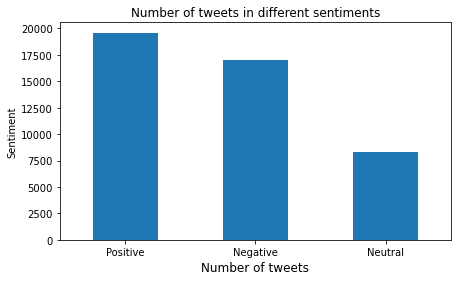

In [10]:
comp_df.Sentiment.value_counts().plot.bar(figsize=(7,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments',fontsize=12)
plt.xlabel('Number of tweets', fontsize=12)
plt.ylabel('Sentiment')

In [11]:
# Map the sentiment into 0 , 1, 2
comp_df['Sentiment'] = comp_df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})

### Get the month of the tweets

In [12]:
comp_df['month'] = comp_df['TweetAt'].dt.month

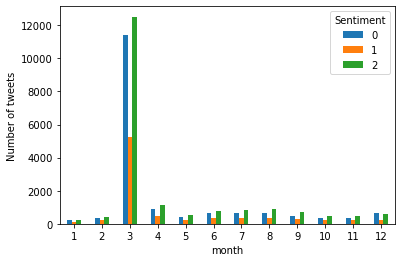

In [13]:
# Visual the date with the labels
pd.crosstab(comp_df.month, comp_df.Sentiment).plot.bar()
plt.ylabel('Number of tweets')
plt.xticks(rotation=None)
plt.show()

### Drop the other columns

In [14]:
# In this task we will focus on the text data only, so we drop the other columns
comp_df = comp_df[['OriginalTweet','Sentiment','is_test']]

### Modify the tweet contents

#### Have a look on the  tweets's content

In [15]:
comp_df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

### The elements we would like to remove from the tweet's content

- URL
- punctuations
- \# tags
- @ tags
- extra space

In [16]:
# Change columns name for easy access
comp_df.columns =['tweet','label','is_test']

In [17]:
#Remove @ tags
comp_df.tweet = comp_df.tweet.str.replace(r'(@\w*)','')

#Remove URL
comp_df.tweet = comp_df.tweet.str.replace(r"http\S+", "")

#Remove # tag
comp_df.tweet = comp_df.tweet.str.replace(r'#\w+',"")

#Remove all non-character
comp_df.tweet = comp_df.tweet.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
comp_df.tweet = comp_df.tweet.str.replace(r'( +)'," ")
comp_df.tweet = comp_df.tweet.str.strip()

# Change to lowercase
comp_df.tweet = comp_df.tweet.str.lower()

In [18]:
comp_df.tweet[60]

'consumer corner taking advantage of fears'

### Tokenize and Lemmatize the word in data

In [19]:
# Create new columns for storing
comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]
lemma = nltk.WordNetLemmatizer()
comp_df.corpus = comp_df.apply(lambda x: [lemma.lemmatize(word) for word in x.corpus], axis=1)
comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)

### Visualize the text data using wordcloud

In [20]:
stop_words = stopwords.words('english')

In [21]:
text = comp_df.corpus.values
wordcloud = WordCloud(max_words=500,background_color='white', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

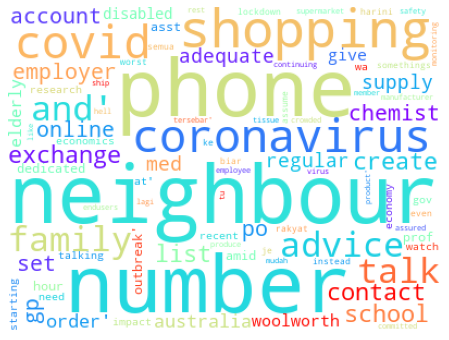

In [22]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Start modeling

In [23]:
# Import the tools we need
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [24]:
# Split the data back to train and test set
train_df = comp_df[comp_df.is_test==0]
test_df = comp_df[comp_df.is_test==1]
train_df.drop('is_test',axis=1, inplace=True)
test_df.drop('is_test',axis=1, inplace=True)
test_df.reset_index(drop=True,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
#Split the data in X and y dataset

x_df = train_df.corpus
y_df = train_df['label']

x_test = test_df.corpus
y_test =test_df['label']

# Split to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_df,y_df, test_size=0.2,random_state=42)

In [26]:
# Check the shape
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((32925,), (8232,), (32925,), (8232,))

# Using CountVectorizer

In [27]:
# Create the vectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(comp_df.corpus)

# transform both train and valid data
x_train_vector = vectorizer.transform(x_train)
x_val_vector = vectorizer.transform(x_val)

### Start training models
- Logistric Regression
- Naive Bayes

In [28]:
cross_val_score(LogisticRegression(random_state=42), x_train_vector, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished


0.7938954514879126

In [29]:
cross_val_score(MultinomialNB(alpha=0.01), x_train_vector, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.6661198281711749

In [30]:
model = LogisticRegression(random_state=42).fit(x_train_vector, y_train)
print(classification_report(y_val, model.predict(x_val_vector)))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3062
           1       0.70      0.74      0.71      1553
           2       0.83      0.84      0.83      3617

    accuracy                           0.80      8232
   macro avg       0.78      0.79      0.78      8232
weighted avg       0.80      0.80      0.80      8232



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### The performance of logistric regression is better, now try to tune the hyperparameters.

In [31]:
#params = {
    #'solver':['liblinear','saga','newton-cg','lbfgs'],
   # 'C':[0.001,0.01,0.1,1,10,100],
    # 'penalty':['l1','l2']
}

#lr_grid = GridSearchCV(LogisticRegression(random_state=42),params, cv=5, verbose=2, n_jobs=-1)
#lr_grid.fit(x_train_vector, y_train)

#print(classification_report(y_val, lr_grid.predict(x_val_vector)))

SyntaxError: invalid syntax (<ipython-input-31-01e061b0a130>, line 5)

# Use tf-idf as vectorizer

In [32]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(comp_df.corpus)

x_train_tf = vectorizer.transform(x_train)
x_val_tf = vectorizer.transform(x_val)

Text(0.5, 0, 'Weight')

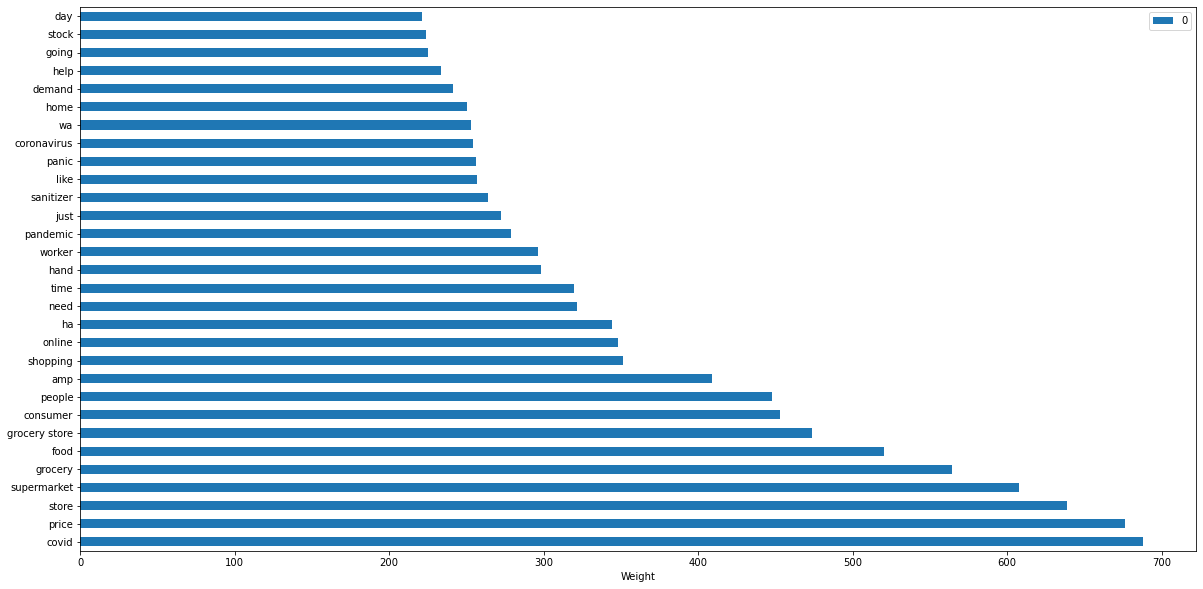

In [33]:
# Show the top 20 words 
feature_weight = x_train_tf.sum(axis=0).tolist()[0]
features = pd.DataFrame(feature_weight)
features.index =  list(vectorizer.get_feature_names())
features.sort_values(by=[0],ascending=False).head(30).plot.barh(figsize=(20,10))
plt.xlabel('Weight')

### Model training
- logistric regression

In [34]:
model = LogisticRegression(random_state=42).fit(x_train_tf,y_train)
print(classification_report(y_val, model.predict(x_val_tf)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3062
           1       0.74      0.60      0.66      1553
           2       0.80      0.85      0.83      3617

    accuracy                           0.79      8232
   macro avg       0.78      0.75      0.76      8232
weighted avg       0.79      0.79      0.78      8232



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Hyperparameters tuning using gridsearch

In [35]:
#params = {
    #'solver':['liblinear','saga','newton-cg','lbfgs'],
    #'C':[0.001,0.01,0.1,1,10,100],
    #'penalty':['l1','l2']
}

#lr_grid02 = GridSearchCV(LogisticRegression(random_state=42),params, cv=10, verbose=2, n_jobs=-1)
#lr_grid02.fit(x_train_tf, y_train)

#print(classification_report(y_val, lr_grid02.predict(x_val_tf)))

SyntaxError: invalid syntax (<ipython-input-35-e047b0210681>, line 5)

In [36]:
#lr_grid.best_estimator_

# Prediction on test data

In [37]:
#To skip the training time on kaggle, I use the best parameter found in my notebook directly
best_model = LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')
best_model.fit(x_train_tf, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

In [38]:
# The best model performance on validation dataset
print(classification_report(y_val, best_model.predict(x_val_tf)))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3062
           1       0.72      0.82      0.77      1553
           2       0.87      0.85      0.86      3617

    accuracy                           0.83      8232
   macro avg       0.81      0.83      0.82      8232
weighted avg       0.83      0.83      0.83      8232



### Now do prediction on the test data

In [39]:
x_test_tf = vectorizer.transform(x_test)

In [40]:
y_pred = best_model.predict(x_test_tf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1633
           1       0.67      0.77      0.72       619
           2       0.83      0.84      0.83      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.80      0.79      3798
weighted avg       0.81      0.80      0.80      3798



### Heat map of the prediction

Text(0.5, 15.0, 'Predicted')

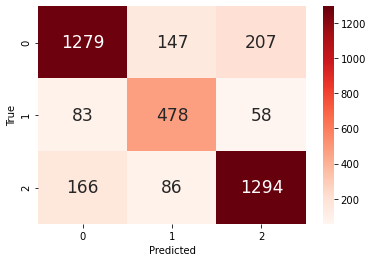

In [41]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',annot_kws={'size':17}, cmap='Reds')
plt.ylabel('True')
plt.xlabel('Predicted')

## Thank you very much